In [3]:
%load_ext autoreload
%autoreload 2

In [210]:
import pandas as pd, numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import plotnine as pn

import mtg
from importlib import reload
reload(mtg);

In [5]:
past_games = mtg.PastGames()

## Training a surrogate over the historical games.

/home/mson/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/mson/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: l2_lambda
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[1]	training's binary_logloss: 0.690985	valid_1's binary_logloss: 0.691162
[2]	training's binary_logloss: 0.689086	valid_1's binary_logloss: 0.689383
[3]	training's binary_logloss: 0.687338	valid_1's binary_logloss: 0.687679
[4]	training's binary_logloss: 0.685845	valid_1's binary_logloss: 0.686323
[5]	training's binary_logloss: 0.684501	valid_1's binary_logloss: 0.685007
[6]	training's binary_logloss: 0.68322	valid_1's binary_logloss: 0.683867
[7]	training's binary_logloss: 0.681762	valid_1's binary_logloss: 0.682466
[8]	training's binary_logloss: 0.680689	valid_1's binary_logloss: 0.681548
[9]	training's binary_logloss: 0.67929	valid_1's binary_logloss: 0.680198
[10]	training's binary_logloss: 0.678426	valid_1's binary_logloss: 0.679316
[11]	training's binary_logloss: 0.677585	valid_1's binary_logloss: 0.678537
[12

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

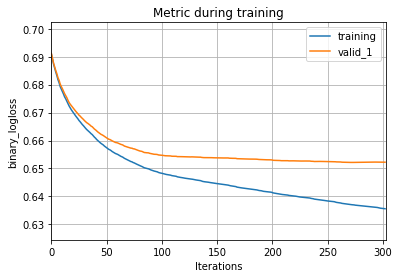

In [139]:
lgb_params = {'objective': 'binary', 'num_leaves': 32, 'l2_lambda': 0.3, 'max_depth': -1}

model = lgb.LGBMClassifier(**lgb_params, num_boost_round=1000)
trn, val = past_games.dsets.sets['trn'], past_games.dsets.sets['val']
model.fit(**past_games.dsets.sets['trn'], eval_set=[(trn['X'], trn['y']), (val['X'], val['y'])],
          early_stopping_rounds=30)
pos_idx = np.argmax(model.classes_)
lgb.plot_metric(model)

## Evaluating the surrogate.

In [162]:
y = past_games.dsets.sets['tst']['y']
pred = model.predict_proba(past_games.dsets.sets['tst']['X'])[:, pos_idx]
roc_auc_score(y_true=y, y_score=pred)

0.6612831071962373

##### Calibrated?

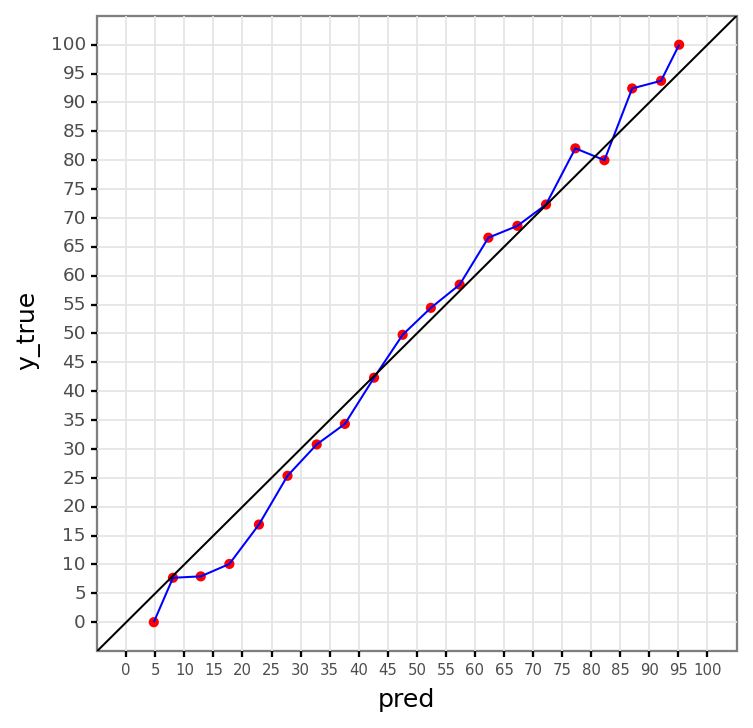

<ggplot: (8787157442338)>

In [264]:
pn.options.dpi = 165
mtg.CalibrationAnalyzer(y, pred).plot

### Seeing which of all possible decks the surrogate favors against the rival's.

In [ ]:
rival_deck = mtg.RivalDeck(past_games).deck

In [129]:
possibles = mtg.PossibleDecks(past_games)
decks = possibles.generate_decks()

In [287]:
deck_defeater = mtg.DeckDefeater(model, decks, rival_deck)
assert (deck_defeater.possible_games.columns == past_games.dsets.sets['trn']['X'].columns).all()
print(f"Mean win probability: {deck_defeater.mean_win_proba:.0%}\n\n")
print(f"Best deck:\n{deck_defeater.best_deck_str}")

In [286]:
deck_defeater.possible_decks_and_predictions

,Alessin_Adamant_Angel_Deck_A_Count,Bold_Battalion_Deck_A_Count,Dreadwing_Darkfire_Dragon_Deck_A_Count,Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count,Gentle_Guard_Deck_A_Count,Horrible_Hooligan_Deck_A_Count,Kindly_Knight_Deck_A_Count,Lilac_Lotus_Deck_A_Count,Murderous_Minotaur_Deck_A_Count,Patchy_Pirate_Deck_A_Count,Sword_of_Shadows_Deck_A_Count,Virtuous_Vigilante_Deck_A_Count,p
0,5,0,0,0,0,3,0,3,0,0,1,0,0.669096
1,2,0,0,7,0,0,0,3,0,0,0,0,0.665943
2,5,4,0,0,0,0,0,2,1,0,0,0,0.663910
3,5,4,0,0,0,0,1,2,0,0,0,0,0.663456
4,5,0,0,0,0,1,0,2,0,3,1,0,0.661321
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352073,0,0,0,0,1,1,0,9,0,1,0,0,0.025138
1352074,0,0,0,0,2,1,0,9,0,0,0,0,0.024221
1352075,0,0,0,0,3,0,0,9,0,0,0,0,0.023949
1352076,0,0,0,0,2,0,0,9,0,1,0,0,0.022966
